In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, log_loss

# Lectura del DataFrame

In [2]:
df = pd.read_csv("/work/data/interim/000_preprocessed.csv")

In [3]:
df.shape

(6819, 96)

In [4]:
df_Corr = pd.read_csv("/work/data/interim/001_Correlation.csv")

## Correction de la mala distribución del target

In [5]:
class_dist = pd.DataFrame(df['bankrupt'].value_counts())
class_dist['Bankrupt? %'] = round((class_dist['bankrupt']/sum(class_dist['bankrupt']))*100,2)
class_dist['Bankrupt? %'] = class_dist['Bankrupt? %'].apply(str)
class_dist['Bankrupt? %'] = class_dist['Bankrupt? %'] +"%"

print("Bankruptcy distribution :\n")
print(class_dist)

Bankruptcy distribution :

   bankrupt Bankrupt? %
0      6599      96.77%
1       220       3.23%


### Separación de features y target

In [6]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [7]:
Xcorr = df_Corr.iloc[:, 1:]
ycorr = df_Corr.iloc[:, 0]

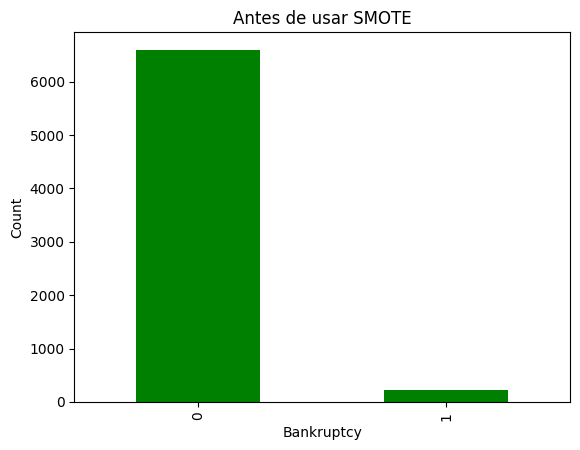

In [8]:
y.value_counts().plot(kind="bar", color='green')
plt.xlabel("Bankruptcy")
plt.ylabel("Count")
plt.title("Antes de usar SMOTE")
plt.show()

In [9]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [10]:
Xcorr, ycorr = sm.fit_resample(X, y)

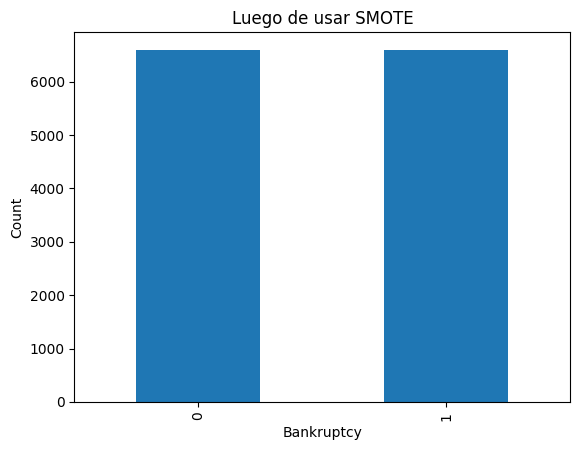

In [11]:
y_res.value_counts().plot(kind="bar")
plt.xlabel("Bankruptcy")
plt.ylabel("Count")
plt.title("Luego de usar SMOTE")
plt.show()

# Normalizar datos

In [12]:
scaler = StandardScaler()

In [13]:
X_res = scaler.fit_transform(X_res)

In [14]:
#Datos normalizados
X_res

array([[-1.19412037, -0.93315781, -1.24713017, ..., -0.12167528,
         0.        , -0.43023409],
       [ 0.01517511,  0.30456147,  0.09247527, ...,  0.47481264,
         0.        , -0.33542118],
       [-0.47810671, -0.1216455 , -0.44388388, ..., -0.15518038,
         0.        , -0.43011631],
       ...,
       [-0.98190891, -1.00736908, -0.93002353, ..., -0.04564005,
         0.        , -0.35670211],
       [-1.08802453, -0.849256  , -1.12868019, ..., -0.17934132,
         0.        , -0.42008751],
       [-2.63215046, -2.23037083, -2.67423251, ..., -0.0285865 ,
         0.        , -0.48420055]])

# División de datos de entrenamiento y prueba

Para esta división, se tomara el 80% de los datos para el entrenamiento y el 20% para test. Se usa un random_state de 0 para garantizar reproducibilidad.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=0)
Xcorr_train, Xcorr_test, ycorr_train, ycorr_test = train_test_split(Xcorr, ycorr, test_size=0.3, random_state=0)

Validamos las dimensiones de los conjuntos

In [16]:
X_train.shape, y_train.shape

((9238, 95), (9238,))

# PCA y KPCA

## PCA

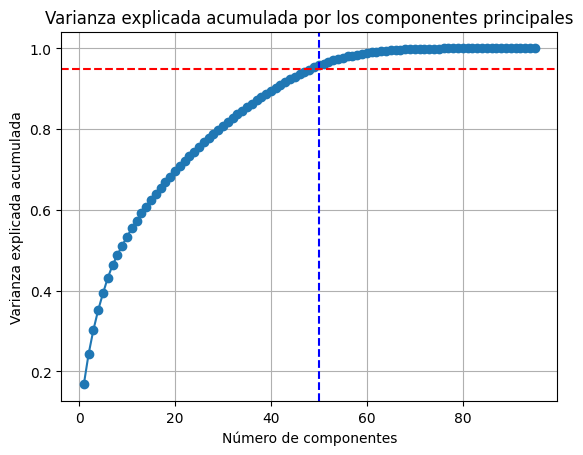

In [17]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por los componentes principales')
plt.grid(True)
# only one line may be specified; ymin & ymax specified as a percentage of y-range
plt.axvline(x=50, color='b', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()


In [15]:
pca = PCA(n_components=50)
pca.fit(X_train)
#X_pca = pca.transform(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
varianza_explicada = pca.explained_variance_ratio_
print("Varianza explicada:", varianza_explicada)


## KPCA

In [16]:
kernels = ['linear', 'poly']

In [17]:
def get_best_kernel(kernels):
    # Itera sobre los kernels y calcula la varianza explicada de cada componente y la acumulada
    for kernel in kernels:
        print("="*25, kernel, "="*25)
        # Varianza acumulada objetivo
        target_variance = 0.95
        # Crea el objeto KernelPCA con el kernel correspondiente
        kpca = KernelPCA(n_components=None, kernel=kernel)
        
        # Ajusta el modelo de KernelPCA y transforma los datos
        data_kpca = kpca.fit_transform(X_train)
        
        # Calcula la matriz de covarianza de los datos transformados
        cov_matrix = np.cov(data_kpca.T)
        
        # Calcula los autovalores y autovectores de la matriz de covarianza
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        # Ordena los autovalores en orden descendente
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        
        # Calcula la varianza explicada de cada componente
        explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)
        
        # Calcula la varianza explicada acumulada
        explained_variance_cumulative = np.cumsum(explained_variance)
        
        # Encuentra el número de componentes que alcanza la varianza acumulada objetivo
        num_components = np.argmax(explained_variance_cumulative >= target_variance) + 1
        
        # Imprime los resultados
        print(f"Kernel: {kernel}")
        for i, var in enumerate(explained_variance_cumulative):
            print(f"Varianza explicada acumulada del componente {i+1}: {var}")
            if var >= target_variance:
                break
        print(f"Número de componentes para alcanzar una varianza acumulada del {target_variance * 100}%: {num_components}")
        print()

In [18]:
best_kernel = get_best_kernel(kernels)

In [19]:
kpca = KernelPCA(n_components=3, kernel='poly')
X_kpca = kpca.fit_transform(X_train)
X_test_kpca = kpca.transform(X_test)


## Cross Validation PCA / KPCA

### Énfasis en valores Falso Negativos

In [20]:
from sklearn.datasets import make_classification
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score

def cross_validation(model, X_train_pca,X_train_kpca,y_train ):
    # Cross-validation en PCA
    scores_pca_recall = cross_val_score(model, X_train_pca, y_train, cv=5, scoring='recall')
    scores_pca_accuracy = cross_val_score(model, X_train_pca, y_train, cv=5, scoring='accuracy')
    recall_pca = scores_pca_recall.mean()
    accuracy_pca = scores_pca_accuracy.mean()
  

    # Cross-validation en KPCA
    scores_kpca_recall = cross_val_score(model, X_train_kpca, y_train, cv=5, scoring='recall')
    scores_kpca_accuracy = cross_val_score(model, X_train_kpca, y_train, cv=5, scoring='accuracy')
    recall_kpca = scores_kpca_recall.mean()
    accuracy_kpca = scores_kpca_accuracy.mean()

    # Comparar el rendimiento
    print("Recall PCA:", recall_pca)
    print("Recall KPCA:", recall_kpca)
    print("Accuracy PCA:", accuracy_pca)
    print("Accuracy KPCA:", accuracy_kpca)
    

## Matriz de confusión

In [21]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
def print_confusion_matrix(y_true,y_pred):
    
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, annot=labels, fmt="", cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
   

## Reporte de clasificación

In [24]:
from sklearn.metrics import classification_report

def classification_reporting(model,X_test,y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    print_confusion_matrix(y_test,y_pred)
    return y_pred

## Logistic Regression

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1925
           1       0.90      0.91      0.90      2035

    accuracy                           0.90      3960
   macro avg       0.90      0.90      0.90      3960
weighted avg       0.90      0.90      0.90      3960



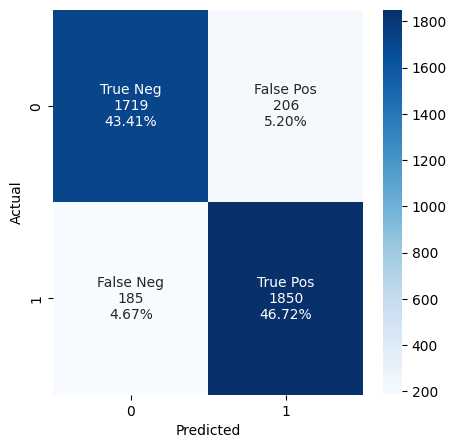

In [25]:
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train,y_train)
log_reg_report=classification_reporting(log_reg_model,X_test,y_test)


### Regresión logística PCA vs KPCA

In [26]:
cross_validation(log_reg_model, X_train_pca ,X_kpca,y_train )

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1925
           1       0.89      0.90      0.89      2035

    accuracy                           0.89      3960
   macro avg       0.89      0.89      0.89      3960
weighted avg       0.89      0.89      0.89      3960



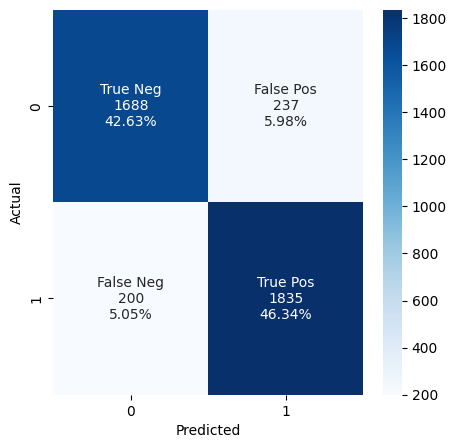

In [27]:
log_reg_model_pca = LogisticRegression(random_state=42)
log_reg_model_pca.fit(X_train_pca,y_train)
log_reg_report=classification_reporting(log_reg_model_pca,X_test_pca,y_test)

## KNN

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1925
           1       0.91      1.00      0.95      2035

    accuracy                           0.95      3960
   macro avg       0.95      0.94      0.95      3960
weighted avg       0.95      0.95      0.95      3960



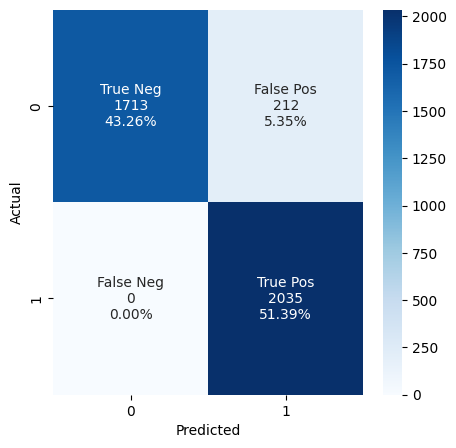

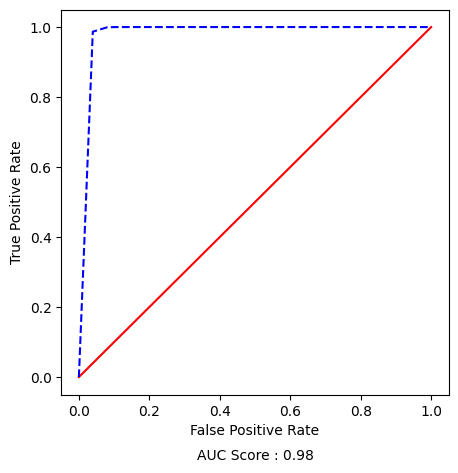

In [59]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train,y_train)
knn_report=classification_reporting(knn_model,X_test,y_test)
plot_auc_roc_curve(knn_model,X_test,y_test)


In [29]:
cross_validation(knn_model, X_train_pca ,X_kpca,y_train )

Recall PCA: 0.9995618838992332
Recall KPCA: 0.9009675063891931
Accuracy PCA: 0.9340766704870657
Accuracy KPCA: 0.8678283140789909


              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1925
           1       0.86      0.88      0.87      2035

    accuracy                           0.86      3960
   macro avg       0.86      0.86      0.86      3960
weighted avg       0.86      0.86      0.86      3960



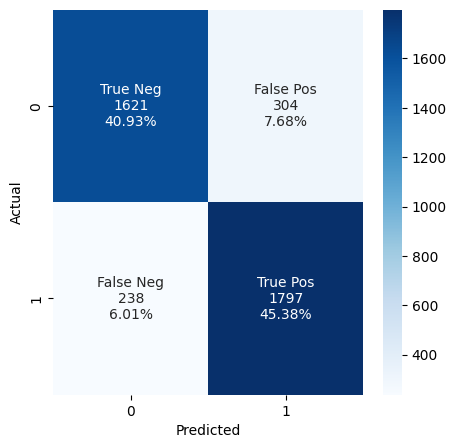

In [37]:
knn_model_kpca = KNeighborsClassifier()
knn_model_kpca.fit(X_kpca,y_train)
knn_model_report=classification_reporting(knn_model_kpca,X_test_kpca,y_test)

## Random Forest

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1925
           1       0.96      0.99      0.98      2035

    accuracy                           0.98      3960
   macro avg       0.98      0.98      0.98      3960
weighted avg       0.98      0.98      0.98      3960



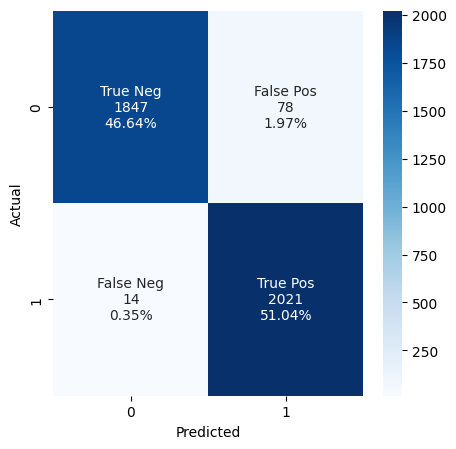

In [68]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train,y_train)
random_forest_report=classification_reporting(random_forest_model,X_test,y_test)

### Random Forest con dataset de correlaciones

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1925
           1       0.97      0.99      0.98      2035

    accuracy                           0.98      3960
   macro avg       0.98      0.98      0.98      3960
weighted avg       0.98      0.98      0.98      3960



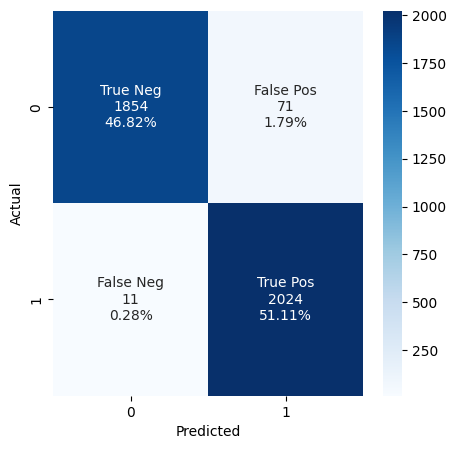

In [67]:
random_forest_model_corr = RandomForestClassifier(random_state=42)
random_forest_model_corr.fit(Xcorr_train,ycorr_train)
random_forest_report_corr=classification_reporting(random_forest_model_corr,Xcorr_test,ycorr_test)

## Gaussian Naive Bayes

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1925
           1       0.82      0.89      0.85      2035

    accuracy                           0.84      3960
   macro avg       0.85      0.84      0.84      3960
weighted avg       0.85      0.84      0.84      3960



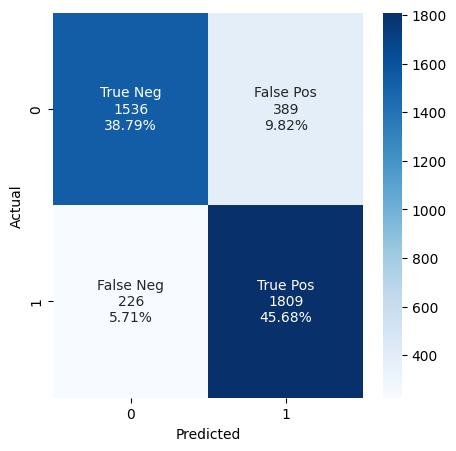

In [32]:
from sklearn.naive_bayes import GaussianNB
gaussian_nb_model = GaussianNB()
gaussian_nb_model.fit(X_train,y_train)
gaussian_nb_perf_report=classification_reporting(gaussian_nb_model,X_test,y_test)


# Comparación de resultados

## Área bajo la curva ROC

In [22]:
def plot_auc_roc_curve(model,X_test,y_test):
    pred_prob = model.predict_proba(X_test)
    
    # roc curve and auc score for model
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    auc_score = roc_auc_score(y_test, pred_prob[:,1])
    
    # roc curve for tpr = fpr (AUC = 0.5)
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
    
    plt.rcParams["figure.figsize"] = (5,5)

    ax = plt.subplots()
    ax = sns.lineplot(x=p_fpr, y=p_tpr, color='r')
    ax = sns.lineplot(x=fpr, y=tpr, color='b',linestyle='dashed')
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
    plt.text(0.5, -0.17, 'AUC Score : '+ str(round(auc_score,2)) , transform=plt.gca().transAxes, ha='center')
    plt.show()


Regresión Logística


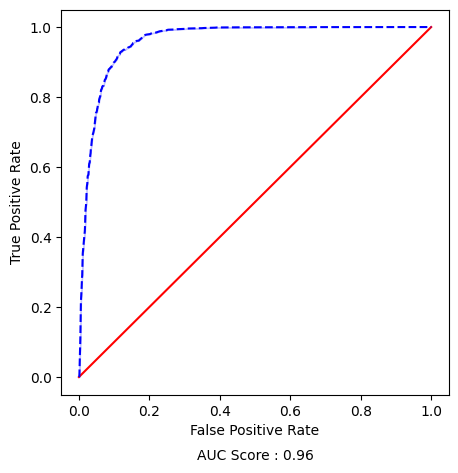

Regresión Logística con PCA


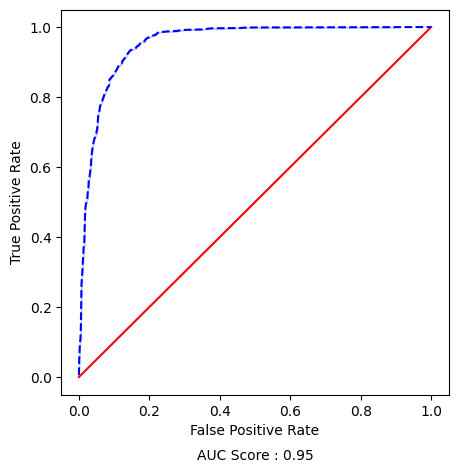

KNN


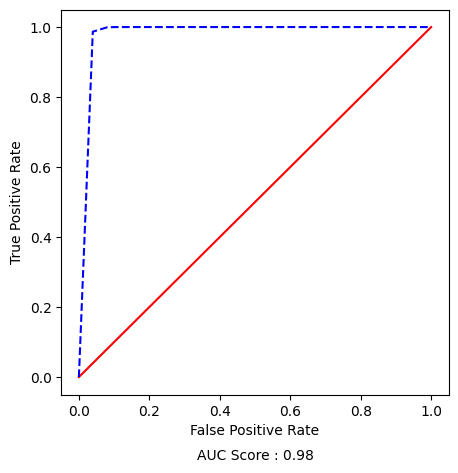

KNN con KPCA


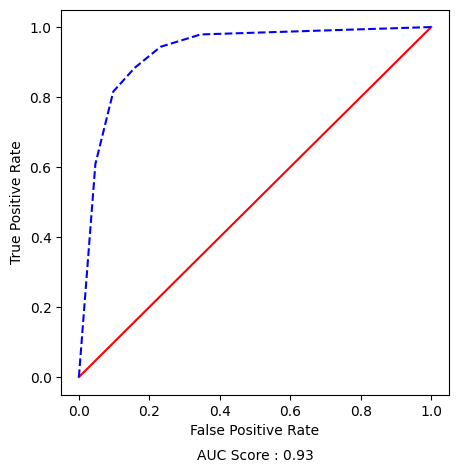

Random Forest


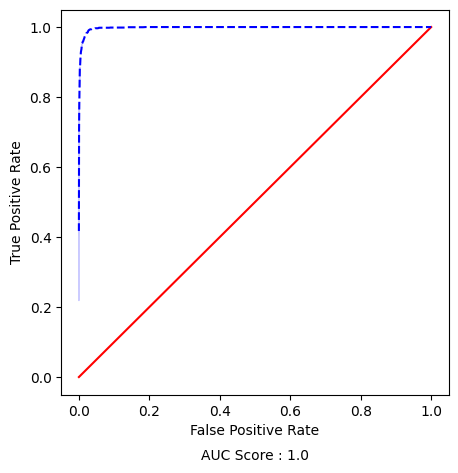

Gaussian NB


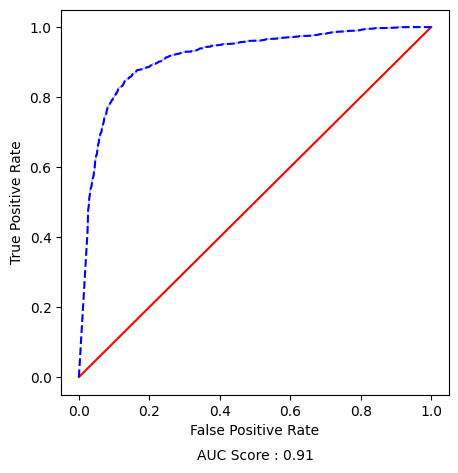

In [72]:
print('Regresión Logística')
plot_auc_roc_curve(log_reg_model,X_test,y_test)
print('Regresión Logística con PCA')
plot_auc_roc_curve(log_reg_model_pca,X_test_pca,y_test)
print('KNN')
plot_auc_roc_curve(knn_model,X_test,y_test)
print('KNN con KPCA')
plot_auc_roc_curve(knn_model_kpca,X_test_kpca,y_test)
print('Random Forest con correlación')
plot_auc_roc_curve(random_forest_model_corr,Xcorr_test,ycorr_test)
print('Gaussian NB')
plot_auc_roc_curve(gaussian_nb_model,X_test,y_test)



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8ba77797-abb8-4bd4-bea9-bb2ef92463f4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>